# Computer Vision Project - Classification of Flowers


In this project your objective is to create a model in order to classify flowers. Thiszip file contains all relevant data. 

1. The data contains two folders: *train* and *test*. The *train* folder consists of 5486-images to use for training while the *test* folder contains 1351-images you can use to test your model in a **train-test-split** validation style. We have omitted another set of 1352 validation images which we will use to benchmark your final models in the last lecture. 


2. We have provided you with two label files: *train_labels.csv* and *test_labels.csv*. Each file contains the filename of the corresponding image and the class label. In total we have **102 different classes** of flowers.  You can import the label files using the `import_labels()` function provided to you in this notebook.


3. Due to the large number of images, there is a good chance that you can not easily fit the entire training and testing data into RAM. We therefore give you an implementation of a `DataGenerator` class that can be used with keras. This class will read in the images from your hard-drive for each batch during during or testing. The class comes with some nice features that could improve your training significantly such as **image resizing**, **data augmentation** and **preprocessing**. Have a look at the code to find out how.

    Initialize data generators using labels and image source directory.

    `
    datagen_train = DataGenerator('train', y_train, batch_size, input_shape, ...)
    datagen_test = DataGenerator('test', y_test, batch_size, input_shape, ...)`

    Train your model using data generators.

    `model.fit(datagen_train, validation_data=datagen_test, ...)`
    
    
4. Select a suitable model for classification. It is up to you to decide all model parameters, such as **number of layers**, **number and size of filter** in each layer, using **pooling** or, **image-size**, **data-augmentation**, **learning rate**, ... 


5. **Document** your progress and your intermediate results (your failures and improvements). Describe why you selected certain model and training parameters, what worked, what did not work. Store the training history (loss and accuracy) and create corresponding plots. This documentation will be part of your final presentation and will be **graded**.


6. Feel free to explore the internet for suitable CNN models and re-use these ideas. If you use certain features we have not touched during the lecture such as Dropout, Residual Learning or Batch Normalization. Prepare a slide in your final presentation to explain in your own (basic) terms what these things to so we can all learn from your experience. **Notice:** Very large models might perform better but will be harder and slower to train. **Do not use a pre-trained model you find online!**


7. Prepare a notebook with your model such that we can use it in the final competition. This means, store your trained model using `model.save(...)`. Your saved models can be loaded via `tf.keras.models.load_model(...)`. We will then provide you with a new folder containing images (*validation*) and a file containing labels (*validation_labels.csv*) which have the same structure. Prepare a data generator for this validation data (test it using the test data) and supply it to the 
 `evaluate_model(model, datagen)` function provided to you.
 
 Your prepared notebook could look like this:
 
    `... import stuff 
    ... code to load the stored model ...
    y_validation = import_labels('validation_labels.csv')
    datagen_validation = DataGenerator('validation', y_validation, batch_size, input_shape)
    evaluate_model(model, datagen_validation)`


8. Prepare a 15-Minute presentation of your findings and final model presentation. A rough guideline what could be interesting to your audience:
    * Explain your models architecture (number of layers, number of total parameters, how long took it to train, ...)
    * Compare the training history of your experimentats visually
    * Explain your best model (why is it better)
    * Why did you take certain decision (parameters, image size, batch size, ...)
    * What worked, what did not work (any ideas why?)
    * **What did you learn?**
    



In [1]:
# Read in label file and return a dictionary {'filename' : label}.
#
def import_labels(label_file):
    labels = dict()

    import csv
    with open(label_file) as fd:
        csvreader = csv.DictReader(fd)

        for row in csvreader:
            labels[row['filename']] = int(row['label'])
    return labels

In [2]:
import tensorflow.keras as keras
from keras.preprocessing import image
import tensorflow as tf
import os
import numpy as np


class DataGenerator(keras.utils.Sequence):

    def __init__(self, img_root_dir, labels_dict, batch_size, target_dim, preprocess_func=None, use_augmentation=False):
        self._labels_dict = labels_dict
        self._img_root_dir = img_root_dir
        self._batch_size = batch_size
        self._target_dim = target_dim
        self._preprocess_func = preprocess_func
        self._n_classes = len(set(self._labels_dict.values()))
        self._fnames_all = list(self._labels_dict.keys())
        self._use_augmentation = use_augmentation

        if self._use_augmentation:
            self._augmentor = image.ImageDataGenerator(
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest',
            )
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self._fnames_all)) / self._batch_size)

    def on_epoch_end(self):
        self._indices = np.arange(len(self._fnames_all))
        np.random.shuffle(self._indices)

    def __getitem__(self, index):
        indices = self._indices[index * self._batch_size:(index+1)*self._batch_size]

        fnames = [self._fnames_all[k] for k in indices]
        X,Y = self.__load_files__(fnames)

        return X,Y

    def __load_files__(self, batch_filenames):
        X = np.empty((self._batch_size, *self._target_dim, 3))
        Y = np.empty((self._batch_size), dtype=int)

        for idx, fname in enumerate(batch_filenames):
            img_path = os.path.join(self._img_root_dir, fname)
            img = tf.keras.utils.load_img(img_path, target_size=self._target_dim)
            x = tf.keras.utils.img_to_array(img)
           
            if self._preprocess_func is not None:
                x = self._preprocess_func(x)

            X[idx,:] = x 
            Y[idx] = self._labels_dict[fname]-1

        if self._use_augmentation:
            it = self._augmentor.flow(X, batch_size=self._batch_size, shuffle=False)
            X = it.next()



        return X, tf.keras.utils.to_categorical(Y, num_classes=self._n_classes)

In [9]:
import matplotlib.pyplot as plt
def plotResults(results):
    acc = results.history['accuracy']
    val_acc = results.history['val_accuracy']
    loss = results.history['loss']
    val_loss = results.history['val_loss']
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Acc')
    plt.plot(val_acc, label='Validation Acc')
    plt.title('Training And Validation Acc')
    plt.legend(loc='lower right')
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training And Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [3]:
def prep(arr):
    scaled_data = (arr - 127.5) / 127.5
    return scaled_data

In [4]:
data_train = DataGenerator("train",import_labels("train_labels.csv"),16,
                        (224,224),prep, use_augmentation=True)

data_test = DataGenerator("test",import_labels("test_labels.csv"),16,
                          (224,224),prep)

While training a custom model, model needed so many epochs to get a significant val_accuracy value


In [8]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(input_shape=(224,224,3),filters=32,kernel_size=(2,2)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(2,2)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(2,2)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(2,2)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(2,2)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(128,activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(102, activation="softmax", name="output_layer"))
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])
results = model.fit(data_train,epochs=50,validation_data = data_test,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
                                                                                tf.keras.callbacks.ModelCheckpoint("custom_model.h5",
                                                                                                                   monitor='val_accuracy',mode='max',save_best_only=True)])

Epoch 1/50
342/342 [==============================] - 59s 170ms/step - loss: 4.3259 - accuracy: 0.0497 - val_loss: 3.8427 - val_accuracy: 0.1071
Epoch 2/50
342/342 [==============================] - 57s 166ms/step - loss: 3.9290 - accuracy: 0.0875 - val_loss: 3.6031 - val_accuracy: 0.1347
Epoch 3/50
342/342 [==============================] - 57s 167ms/step - loss: 3.6084 - accuracy: 0.1219 - val_loss: 3.2547 - val_accuracy: 0.1815
Epoch 4/50
342/342 [==============================] - 57s 167ms/step - loss: 3.4006 - accuracy: 0.1531 - val_loss: 2.9346 - val_accuracy: 0.2649
Epoch 5/50
342/342 [==============================] - 58s 168ms/step - loss: 3.2121 - accuracy: 0.1838 - val_loss: 2.8724 - val_accuracy: 0.2835
Epoch 6/50
342/342 [==============================] - 56s 162ms/step - loss: 3.0730 - accuracy: 0.2136 - val_loss: 2.6735 - val_accuracy: 0.2820
Epoch 7/50
342/342 [==============================] - 54s 157ms/step - loss: 2.9422 - accuracy: 0.2357 - val_loss: 2.6360 - val_ac

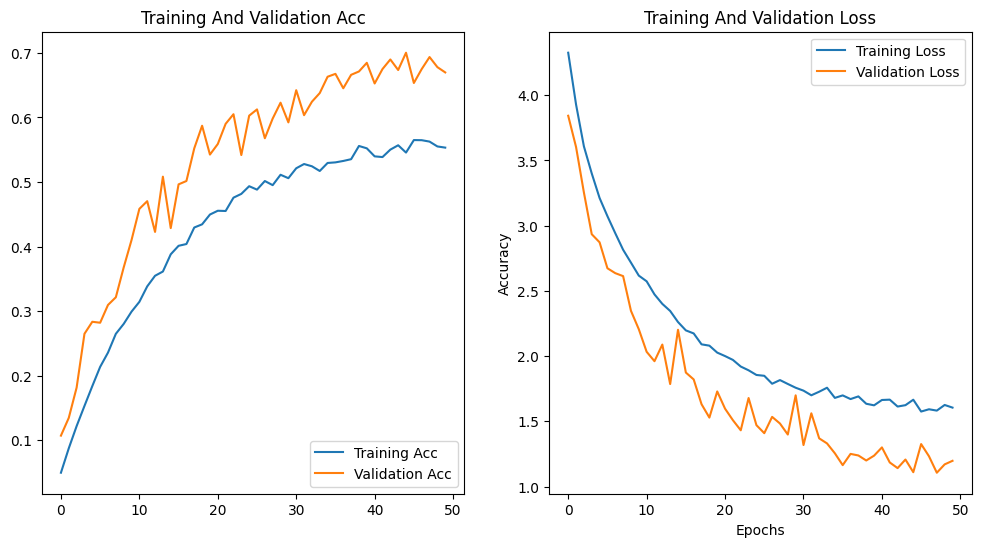

In [10]:
plotResults(results)

Model still can learn, we continue to train

In [15]:
results = model.fit(data_train,epochs=20,validation_data = data_test,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
                                                                                tf.keras.callbacks.ModelCheckpoint("custom_model.h5",
                                                                                                                   monitor='val_accuracy',mode='max',save_best_only=True)])

Epoch 1/20
342/342 [==============================] - 59s 171ms/step - loss: 1.4986 - accuracy: 0.5914 - val_loss: 1.0232 - val_accuracy: 0.7240
Epoch 2/20
342/342 [==============================] - 57s 166ms/step - loss: 1.5036 - accuracy: 0.5824 - val_loss: 1.0358 - val_accuracy: 0.7217
Epoch 3/20
342/342 [==============================] - 57s 167ms/step - loss: 1.5004 - accuracy: 0.5908 - val_loss: 1.1241 - val_accuracy: 0.7091
Epoch 4/20
342/342 [==============================] - 56s 164ms/step - loss: 1.4927 - accuracy: 0.5956 - val_loss: 1.1411 - val_accuracy: 0.7202
Epoch 5/20
342/342 [==============================] - 57s 166ms/step - loss: 1.5169 - accuracy: 0.5906 - val_loss: 1.1246 - val_accuracy: 0.7135
Epoch 6/20
342/342 [==============================] - 54s 158ms/step - loss: 1.4658 - accuracy: 0.5921 - val_loss: 0.9938 - val_accuracy: 0.7321
Epoch 7/20
342/342 [==============================] - 52s 153ms/step - loss: 1.4968 - accuracy: 0.5947 - val_loss: 1.1607 - val_ac

After 100 epochs, the accuracies reached a plateau.

In [16]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(input_shape=(224,224,3),filters=32,kernel_size=(2,2)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(2,2)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(128,activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(102, activation="softmax", name="output_layer"))
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])
results = model.fit(data_train,epochs=50,validation_data = data_test,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
                                                                                tf.keras.callbacks.ModelCheckpoint("custom_model.h5",
                                                                                                                   monitor='val_accuracy',mode='max',save_best_only=True)])

Epoch 1/50
342/342 [==============================] - 58s 169ms/step - loss: 4.2229 - accuracy: 0.0594 - val_loss: 3.8947 - val_accuracy: 0.1019
Epoch 2/50
342/342 [==============================] - 57s 166ms/step - loss: 3.8710 - accuracy: 0.0905 - val_loss: 3.7500 - val_accuracy: 0.1287
Epoch 3/50
342/342 [==============================] - 59s 172ms/step - loss: 3.7365 - accuracy: 0.1087 - val_loss: 3.7282 - val_accuracy: 0.1161
Epoch 4/50
342/342 [==============================] - 60s 176ms/step - loss: 3.6486 - accuracy: 0.1204 - val_loss: 3.6388 - val_accuracy: 0.1496
Epoch 5/50
342/342 [==============================] - 62s 181ms/step - loss: 3.5723 - accuracy: 0.1347 - val_loss: 3.5279 - val_accuracy: 0.1682
Epoch 6/50
342/342 [==============================] - 58s 169ms/step - loss: 3.5423 - accuracy: 0.1360 - val_loss: 3.6634 - val_accuracy: 0.1362
Epoch 7/50
342/342 [==============================] - 58s 170ms/step - loss: 3.4904 - accuracy: 0.1466 - val_loss: 3.6664 - val_ac

In [6]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,input_shape=(224,224,3))
for i in base_model.layers[:-50]:
    i.trainable = False
model = tf.keras.models.Sequential([base_model,tf.keras.layers.GlobalAveragePooling2D(),
                                    tf.keras.layers.Dense(128,activation="relu"),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(102, activation="softmax", name="output_layer")])

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])
results = model.fit(data_train,epochs=50,validation_data = data_test,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
                                                                                tf.keras.callbacks.ModelCheckpoint("model.h5",
                                                                                                                   monitor='val_accuracy',mode='max',save_best_only=True)])

Epoch 1/50
342/342 [==============================] - 72s 195ms/step - loss: 3.6993 - accuracy: 0.2100 - val_loss: 2.7464 - val_accuracy: 0.4040
Epoch 2/50
342/342 [==============================] - 61s 180ms/step - loss: 1.9725 - accuracy: 0.5470 - val_loss: 1.1524 - val_accuracy: 0.7321
Epoch 3/50
342/342 [==============================] - 75s 219ms/step - loss: 1.1931 - accuracy: 0.7147 - val_loss: 0.6816 - val_accuracy: 0.8475
Epoch 4/50
342/342 [==============================] - 60s 175ms/step - loss: 0.8254 - accuracy: 0.8026 - val_loss: 0.4068 - val_accuracy: 0.9010
Epoch 5/50
342/342 [==============================] - 57s 167ms/step - loss: 0.6438 - accuracy: 0.8485 - val_loss: 0.3304 - val_accuracy: 0.9174
Epoch 6/50
342/342 [==============================] - 57s 166ms/step - loss: 0.4855 - accuracy: 0.8869 - val_loss: 0.2548 - val_accuracy: 0.9308
Epoch 7/50
342/342 [==============================] - 57s 168ms/step - loss: 0.3904 - accuracy: 0.9061 - val_loss: 0.2537 - val_ac

### Flatten layer is not that important.
### LearningRateScheduler 
### EarlyStopping
### ModelCheckpoint

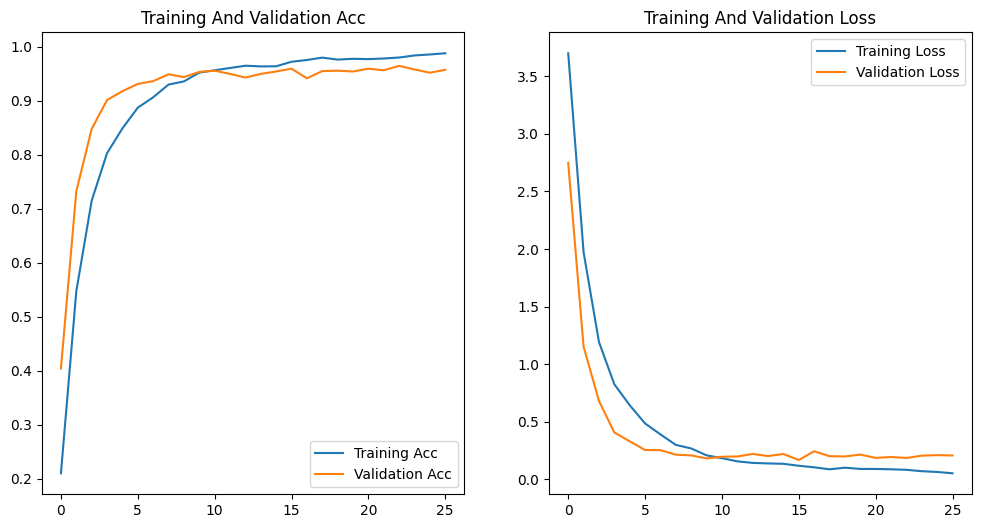

In [12]:
plotResults(results)

In [7]:
saved_model = tf.keras.models.load_model("model.h5")

_,acc= saved_model.evaluate(data_test)
acc

84/84 [==============================] - 6s 63ms/step - loss: 0.1857 - accuracy: 0.9643


0.9642857313156128

In [8]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 output_layer (Dense)        (None, 102)               13158     
                                                                 
Total params: 2,435,110
Trainable params: 2,032,230
Non-

# RESNET50

In [11]:
from keras.applications.resnet import preprocess_input
data_train = DataGenerator("train",import_labels("train_labels.csv"),16,
                        (224,224),preprocess_input, use_augmentation=True)

data_test = DataGenerator("test",import_labels("test_labels.csv"),16,
                          (224,224),preprocess_input)

In [13]:
base_resnet = tf.keras.applications.ResNet50(False,"imagenet",input_shape=(224,224,3))

for i in base_resnet.layers[:-75]:
    i.trainable = False

resnet = tf.keras.models.Sequential([base_resnet,tf.keras.layers.GlobalAveragePooling2D(),
                                    tf.keras.layers.Dense(256,activation="relu"),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(102, activation="softmax", name="output_layer")])



resnet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])
results = resnet.fit(data_train,epochs=50,validation_data = data_test,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
                                                                                tf.keras.callbacks.ModelCheckpoint("resnet_model.h5",
                                                                                                                   monitor='val_accuracy',mode='max',save_best_only=True)])

Epoch 1/50
342/342 [==============================] - 67s 182ms/step - loss: 3.1274 - accuracy: 0.3147 - val_loss: 2.2381 - val_accuracy: 0.5350
Epoch 2/50
342/342 [==============================] - 64s 186ms/step - loss: 1.3749 - accuracy: 0.6400 - val_loss: 1.0602 - val_accuracy: 0.7299
Epoch 3/50
342/342 [==============================] - 71s 207ms/step - loss: 0.8125 - accuracy: 0.7761 - val_loss: 0.5283 - val_accuracy: 0.8631
Epoch 4/50
342/342 [==============================] - 68s 198ms/step - loss: 0.5760 - accuracy: 0.8346 - val_loss: 0.3917 - val_accuracy: 0.8884
Epoch 5/50
342/342 [==============================] - 63s 184ms/step - loss: 0.4235 - accuracy: 0.8878 - val_loss: 0.4336 - val_accuracy: 0.8966
Epoch 6/50
342/342 [==============================] - 58s 170ms/step - loss: 0.3584 - accuracy: 0.9015 - val_loss: 0.4431 - val_accuracy: 0.9040
Epoch 7/50
342/342 [==============================] - 60s 175ms/step - loss: 0.3028 - accuracy: 0.9152 - val_loss: 0.3118 - val_ac

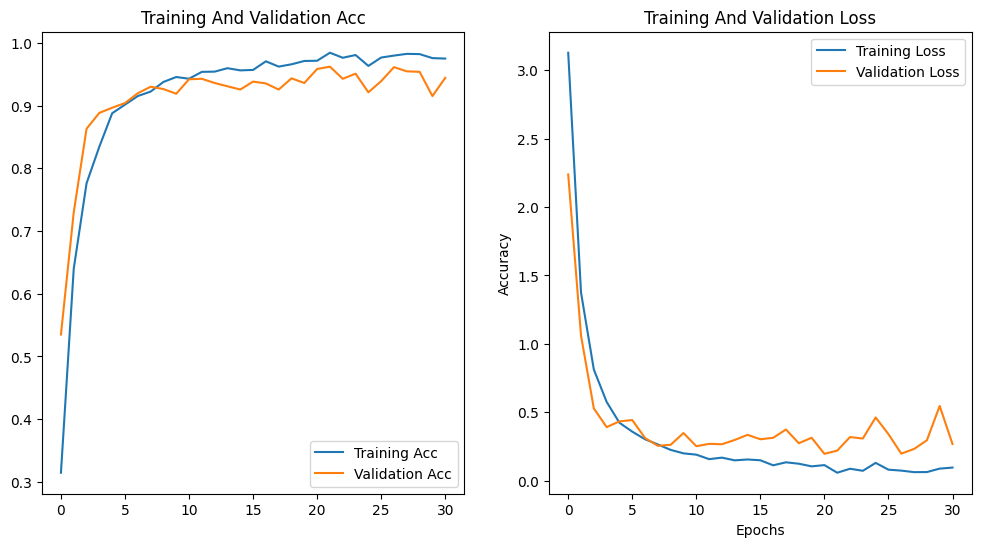

In [19]:
plotResults(results)

In [17]:
base_vgg16 = tf.keras.applications.VGG16(False,"imagenet",input_shape=(224,224,3))

for i in base_vgg16.layers[:-20]:
    i.trainable = False

resnet = tf.keras.models.Sequential([base_vgg16,tf.keras.layers.GlobalAveragePooling2D(),
                                    tf.keras.layers.Dense(256,activation="relu"),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(102, activation="softmax", name="output_layer")])



resnet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])
results = resnet.fit(data_train,epochs=50,validation_data = data_test,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5),
                                                                                tf.keras.callbacks.ModelCheckpoint("resnet_model.h5",
                                                                                                                   monitor='val_accuracy',mode='max',save_best_only=True)])

Epoch 1/50
342/342 [==============================] - 199s 503ms/step - loss: 4.5963 - accuracy: 0.0272 - val_loss: 4.5730 - val_accuracy: 0.0268
Epoch 2/50
336/342 [============================>.] - ETA: 2s - loss: 4.5692 - accuracy: 0.0257

KeyboardInterrupt: 

When I tried VGG16 and VGG19 models with the same architecture and parameters, I got an error message "ResourceExhaustedError"